# 第四章 查询扩展 Query Expansion

## 目录
- [4.1 - Expansion with generator answers（生成器答案扩展）](#41-expansion-with-generator-answers生成器答案扩展)
- [4.2 - Expansion with multiple queries（多个查询的查询扩展）](#42-expansion-with-multiple-queries多个查询的查询扩展)
- [4.3 - 总结](#43-总结)

我们将通过Expansion with generator answers和Expansion with multiple queries两个例子，学习使用查询增强的方法，来帮助我们改善查询的质量，提供更加精确和丰富的信息。

## 4.1  Expansion with generator answers（生成器答案扩展）


![Expansion with generated answers.png](./images/Expansion%20with%20generated%20answers.png)

我们通过图片了解 Expansion with generator answers 的工作原理：

第一步，我们需要先提出一个查询。

第二步，使用LLM生成问题的答案，以提供相关上下文。

第三步，利用向量数据库（VectorDB）检索原始查询的多个结果，包含附加的上下文。

第四步，再次使用LLM得到最终答案。

让我们开始进行实践。

首先，我们导入要用到的数据。

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='./data/2024年北京市政府工作报告.pdf', \
                                collection_name='beijing_annual_report_2024', \
                                embedding_function=embedding_function,
                                langcode='zh')  # 注意中文文档将langcode改为'zh'
chroma_collection.count()

1028

配置`OPENAI_API_KEY`(在`.env`文件中进行设置)。

In [2]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) 
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

使用`umap`进行投影数据。

In [3]:
import umap.umap_ as umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

D:\Anaconda3\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\Anaconda3\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
D:\Anaconda3\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 

参考paper https://arxiv.org/abs/2305.03653

我们创建名为`augment`的函数，进行生成查询，并传递一个查询，传入模型参数（默认使用`gpt-3.5-turbo`）。

In [4]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 设定一个对话场景，模型被告知扮演一个专业的财经研究助理。
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. " # 系统提示
        },
        {"role": "user", "content": query} # 通过查询作为内容
    ] 
    
    # 定义如何提示模型
    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

进行第一次查询。

In [5]:
original_query = "推动北京财政收入增长的因素是什么?"
# 生成假设答案
hypothetical_answer = augment_query_generated(original_query)
# 联合查询
joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

推动北京财政收入增长的因素是什么? 北京的财政收入增长是受多种因素影响的。一些推动北京财政收入增长的因素包括：

1.
市场经济发展：随着北京市经济的发展壮大，市场规模扩大，企业盈利增加，从而带动财政收入的增长。

2.
投资增加：政府通过引导各种投资，加大基础设施、科技创新等领域的投入，刺激经济增长，促进财政收入的增长。

3.
政府政策支持：政府制定各种支持企业和居民发展的政策，如减税降费政策和扶持实体经济的政策等，从而促进经济活力，增加财政收入。

4.
增值税和消费税收入：随着人们消费水平的提高和经济结构的调整，增值税和消费税收入也会相应增加。

5.
土地出让收入：通过土地出让和房地产交易，政府可以获取土地增值税、契税等收入，为财政收入增长提供了一定的支撑。

总的来说，北京财政收入增长的因素
仅包括经济发展的动力，也涉及到政府政策支持、税收收入增加等多个方面的综合影响。


发送一个查询和假设作为查询响应我们的检索系统。

我们接下来使用Chroma进行查询。

In [6]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

努力建设人民满意的法治政府、创新政府、廉洁政府和服务型政府

加快在政务、医疗、教育、工业、
生活服务等领域应用

更好发挥积极财政政策作用

纵深推进政府系统全面从严治
党

完善疏解激励约束政策体系



将查询结果集的嵌入，原始检索的嵌入，联合查询的嵌入进行投影。


In [7]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


进行可视化。

(-4.898337054252624, 6.464729475975036, 3.1551185965538027, 12.484500992298127)

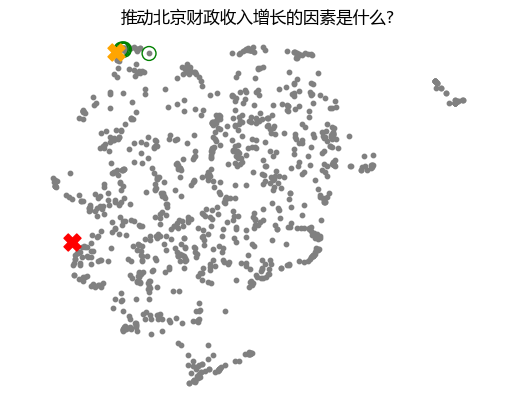

In [8]:
import matplotlib.pyplot as plt


plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

我们可以看到红色的`X`是我们的原始查询，橙色的`X`是我们带有假设答案的查询，绿色的圆圈是我们检索到的查询，可以看出，进行联合查询提高了我们的查询结果。

## 4.2 Expansion with multiple queries（多个查询的查询扩展）

![Expansion with multiple queries.png](./images/Expansion%20with%20multiple%20queries.png)

我们通过图片了解 Expansion with multiple queries 的工作原理：

第一步，我们需要发起一个查询。

第二步，使用大型语言模型（LLM）来生成额外的查询。

第三步，这些新生成的查询被发送到向量数据库（VectorDB）。

第四步，向量数据库检索与原始查询和新查询都相关的结果。

第五步，所有的查询结果被发送回LLM。

第六步，LLM基于所有检索到的信息提供最终的答案。

与上一个方法相同（需要增加更多的系统提示）。

In [9]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            # 为模型提供指令，告诉它扮演一个有用的财经研究助理。
            # 指令包括基于提供的查询生成最多五个相关的额外查询问题。
            # 提示模型生成的问题应该简短，不包含复合句，并涵盖主题的不同方面。
            # 要确保问题是完整的，并且与原始查询相关联。
            # 输出格式为每行一个问题，不要对问题编号。
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

第一次查询。

In [15]:
original_query = "推动北京财政收入增长的因素是什么?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- 北京财政支出的主要方向是什么?
- 北京财政预算中的重点支出项目有哪些?
- 北京财政收入中税收所占比例如何?
- 北京财政资金运用方面有哪些重点举措?
- 北京市的财政政策对经济发展有何影响?


我们可以看到LLM生成的其他增强查询问题。


接下来，我们进行构建查询集，使用Chroma并行处理多个查询（原始查询加增强查询）并打印了每个查询及其检索到的文档。

In [16]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# 对检索到的文档进行重复数据删除
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: 推动北京财政收入增长的因素是什么?

Results:
用好“京策”平台向企业精准提供政策服务

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

优
化提升中央政务环境和城市发展品质

严格落实政府系统
机构改革任务

完善疏解激励约束政策体系

----------------------------------------------------------------------------------------------------
Query: - 北京财政支出的主要方向是什么?

Results:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

压茬推出新的试点政
策

用好“京策”平台向企业精准提供政策服务

制定实施“北京服务”意见和促进民营经济发展壮大行动方案

完成全国首例地方政府专项债券提前偿还试点

----------------------------------------------------------------------------------------------------
Query: - 北京财政预算中的重点支出项目有哪些?

Results:
出台普惠托育政策

是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

并请市政协委员提出
意见

压茬推出新的试点政
策

促进北京普惠健
康保可持续发展

----------------------------------------------------------------------------------------------------
Query: - 北京财政收入中税收所占比例如何?

Results:
是中共北京市委带领全市人民攻坚克难、艰苦奋斗的结果

优
化提升中央政务环境和城市发展品质

用好“京策”平台向企业精准提供政策服务

北京成为国家首批制度型开放试点

制定实施“北京服务”意见和促进民营经济发展壮大行动方案

----------------------------------------------------------------------------------------------------
Query: - 北京财政资金运用方面有哪些重点举措?

Results:
统筹用好政府投资

计算原始查询和增强查询的嵌入，然后使用`umap`将这些嵌入进行绘制投影。

In [17]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:03<00:00,  1.54it/s]


从查询结果中提取嵌入向量，使用`umap`将这些嵌入进行绘制投影。

In [18]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:17<00:00,  1.74it/s]


进行数据可视化。

(-4.898337054252624, 6.464729475975036, 3.1551185965538027, 12.484500992298127)

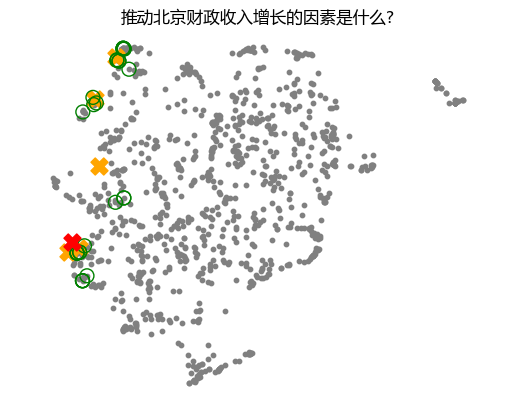

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置全局字体为微软雅黑，显示中文
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

可以看到红色的`X`是我们的原始查询，橙色的`X`是嵌入增强的LLM生成的新查询，绿色的圆圈代表我们实际返回的结果。

## 4.3 总结

通过本次Expansion with generator answers和Expansion with multiple queries两个例子，使用Chroma进行检索的增强，这对于我们找到有效的信息是非常好的。